# Import Necessary Libraries

In [ ]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from subprocess import getoutput
import time
%matplotlib inline
import gymnasium as gym
import text_flappy_bird_gym
import sys
import copy
from tqdm import tqdm
import matplotlib

from collections import defaultdict

# Define Helper Functions for the agents

**Tile Coding Helper Function**

In [ ]:
basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

**Argmax Helper Function**

In [ ]:
def argmax(q_values):
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return np.random.choice(ties)

# Define the Simple TextFlappyBird environment

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
#Hence our x_dist_max=13, x_dist_min=0,y_dist_max=12,y_dist_min=-12 , we will be needing these values in the state-value function plots

# Define the Monte Carlo Control Agent

**Epsilon-greedy policy**

In [ ]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        idx_max = np.argmax(Q[observation])
        probabilities = np.ones(nA) * (epsilon / nA)
        probabilities[idx_max] +=  1.0 - epsilon
        return probabilities
    return policy_fn

**Define the training loop for the MC Control Agent**

In [ ]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=0.9, epsilon=0.8,Q=None):


    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    total_rewards=[]

    scores=[]
    # The final action-value function.
    if Q == None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    old_policy = copy.deepcopy(policy)

    for i in tqdm(range(num_episodes)):
        rewards = []
        states = []
        actions = []

        s = env.reset()[0]
        while True:
            states.append(s)

            # choose one action according to probabilities in the policy
            a = np.random.choice(np.arange(len(policy(s))), 1, p=policy(s))[0]
            actions.append(a)

            s, r, done, _ ,desc= env.step(a)

            rewards.append(r)

            if done:
                scores.append(desc['score'])
                break

        G = 0
        timesteps = len(rewards) - 1
        for t in range(timesteps, -1, -1):
            reward, state, action = rewards[t], states[t], actions[t]


            G = discount_factor * G + reward
            returns_sum[state][action] += G
            returns_count[state][action] += 1

            Q[state][action] = returns_sum[state][action] / returns_count[state][action]
        total_rewards.append(np.sum(rewards))


    return Q, policy,total_rewards,scores


# Define the Sarsa Lamda Agent with tile coding

**Define a tilecoding function for TextFlappyBird**

In [ ]:
class FlappyBirdTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8,width=20,height=15,pipe_gap=4):
        """
        Initializes the TextFlappyBird Tile Coder

        """
        self.iht = IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.screen_size = (width,height)
        self.pipe_gap = pipe_gap


    def get_tiles(self, x, y):
        """
        Takes in x and y from the TextFlappyBird environment
        and returns a numpy array of active tiles.
        """

        x_max = self.screen_size[0]-int(self.screen_size[0]*0.3)-1
        x_min = 0
        y_max = self.screen_size[1]-1-int(self.pipe_gap//2)-1
        y_min = -y_max

        x_scaled = (x-x_min)/(x_max-x_min)*self.num_tiles
        y_scaled = (y-y_min)/(y_max-y_min)*self.num_tiles

        tiles1 = tiles(self.iht, self.num_tilings, [x_scaled, y_scaled])

        return np.array(tiles1)

**Define the Sarsa Lamda Agent**

In [ ]:
class SarsaLamdaAgent():
    """
    Initialization of SarsaLamda Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.lamda = None
        self.method = None
        self.iht_size = None
        self.w = None
        self.z = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.lamda = agent_info.get("lamda", 0.9)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.method = agent_info.get("method", "accumulating")
        self.num_actions = agent_info.get("num_actions", 2)


        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        self.z = np.zeros((self.num_actions, self.iht_size))

        self.tc = FlappyBirdTileCoder(iht_size=self.iht_size,
                                         num_tilings=self.num_tilings,
                                         num_tiles=self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        """
        action_values = []
        chosen_action = None

        action_values = np.zeros(self.num_actions)
        for i in range(self.num_actions):
            action_values[i] = self.w[i][tiles].sum()
        if np.random.random() < self.epsilon:
            chosen_action = np.random.choice(self.num_actions)
        else:

            chosen_action = argmax(action_values)

        return chosen_action, action_values[chosen_action]

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        """
        x, y = state

        active_tiles = self.tc.get_tiles(x, y)
        current_action, action_value = self.select_action(active_tiles)


        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.

        """

        x, y = state


        active_tiles = self.tc.get_tiles(x, y)
        delta = reward
        delta -= self.w[self.last_action][self.previous_tiles].sum()
        if self.method == "accumulating":
            self.z *= self.gamma*self.lamda
            self.z[self.last_action][active_tiles] += 1

        if self.method == "replacing":
            active = np.isin(range(len(self.z[self.last_action])), active_tiles)
            self.z[self.last_action][active] = 1
            self.z[self.last_action][~active] *= self.gamma*self.lamda

        current_action, action_value = self.select_action(active_tiles)

        delta += self.w[current_action][active_tiles].sum()
        self.w += self.alpha * delta *self.z

        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        """

        last_action_value = self.w[self.last_action][self.previous_tiles].sum()
        delta = reward - last_action_value

        self.w += self.alpha * delta * self.z

    def get_value(self, state):
        """Get state value functions
        """
        active_tiles = self.tc.get_tiles(state[0], state[1])
        value = np.sum(self.w[:, active_tiles])
        return value

    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass

    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        """
        pass

**Define the training loop for the Sarsa Lamda Agent**

In [ ]:
def sarsa_lamda(env,num_episodes,epsilon,alpha,gamma):
    agent = SarsaLamdaAgent()
    agent.agent_init({
        "num_tilings": 8,
        "num_tiles": 8,
        "iht_size": 4096,
        "epsilon": epsilon,
        "gamma": gamma,
        "lamda": 0.9,
        "alpha": alpha,
        "initial_weights": 0.0,
        "method": "accumulating",
        "num_actions": 2
    })

    # Create lists to store the total rewards and scores per episode
    total_rewards = []
    total_scores = []
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        action = agent.agent_start(state[0])
        done = False
        rewards = 0
        while not done:
            next_state, reward, done,_,desc = env.step(action)
            action = agent.agent_step(reward, next_state)
            rewards += reward
        total_rewards.append(rewards)
        agent.agent_end(reward)
        total_scores.append(desc['score'])
    return total_rewards,total_scores

# Sensitivity Analysis

**Epsilon exploration rate**

In [ ]:
step_sizes = np.linspace(0.1, 1.0, 10)
rwrds1=[]
rwrds2=[]
for i in step_sizes:
  Q, policy,rewards1,scores1 = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=i)
  rwrds1.append(np.mean(rewards1))
  rewards2,scores2 = sarsa_lamda(env,10000,i,0.5,0.9)
  rwrds2.append(np.mean(rewards2))

100%|██████████| 10000/10000 [01:16<00:00, 131.17it/s]


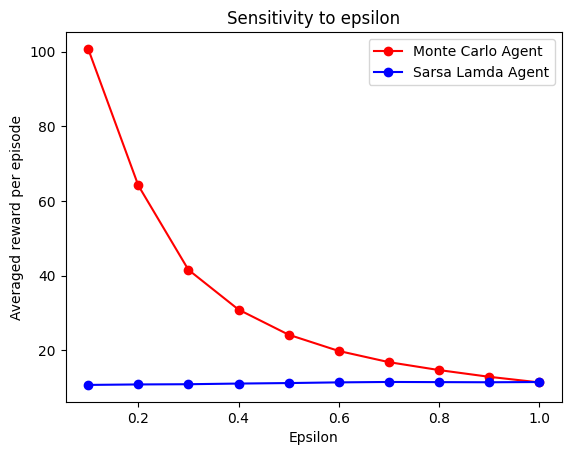

In [ ]:
plt.plot(step_sizes, rwrds1, marker='o', linestyle='solid',color='red',label="Monte Carlo Agent")
plt.plot(step_sizes, rwrds2, marker='o', linestyle='solid',color='blue',label="Sarsa Lamda Agent")
plt.xlabel("Epsilon")
plt.ylabel("Averaged reward per episode")
plt.title("Sensitivity to epsilon")
plt.legend()
plt.show()

**Discount factor**

100%|██████████| 10000/10000 [01:13<00:00, 136.35it/s]


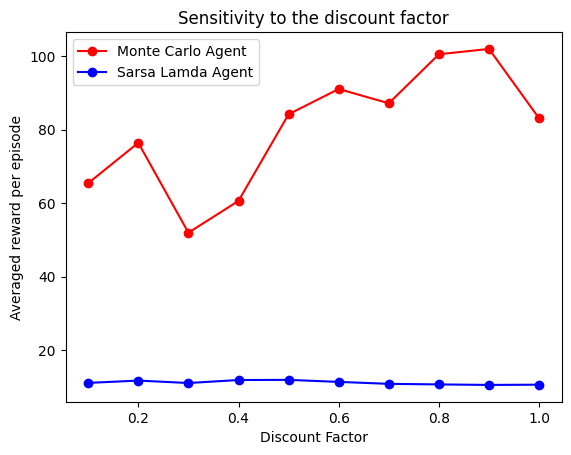

In [ ]:
step_sizes = np.linspace(0.1, 1.0, 10)
rwrds1=[]
rwrds2=[]
for i in step_sizes:
  Q, policy,rewards1,scores1 = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1,discount_factor=i)
  rwrds1.append(np.mean(rewards1))
  rewards2,scores2 = sarsa_lamda(env,10000,0.1,0.5,i)
  rwrds2.append(np.mean(rewards2))
plt.plot(step_sizes, rwrds1, marker='o', linestyle='solid',color='red',label="Monte Carlo Agent")
plt.plot(step_sizes, rwrds2, marker='o', linestyle='solid',color='blue',label="Sarsa Lamda Agent")
plt.xlabel("Discount Factor")
plt.ylabel("Averaged reward per episode")
plt.title("Sensitivity to the discount factor")
plt.legend()
plt.show()

**Step size**

100%|██████████| 10000/10000 [00:13<00:00, 721.55it/s]


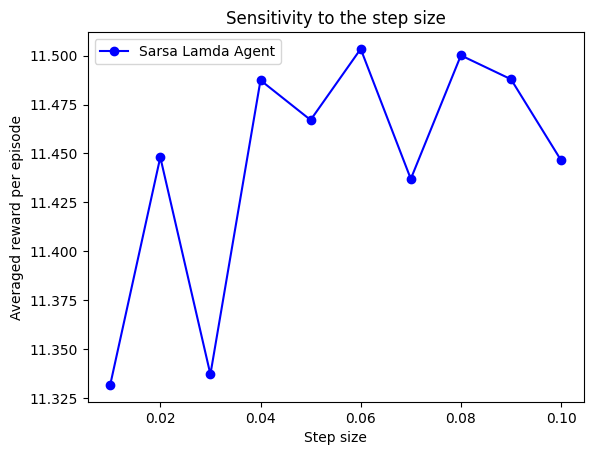

In [ ]:
step_sizes = np.linspace(0.01, 0.1, 10)
rwrds2=[]
for i in step_sizes:
  rewards2,scores2 = sarsa_lamda(env,10000,0.1,i,0.4)
  rwrds2.append(np.mean(rewards2))
plt.plot(step_sizes, rwrds2, marker='o', linestyle='solid',color='blue',label="Sarsa Lamda Agent")
plt.xlabel("Step size")
plt.ylabel("Averaged reward per episode")
plt.title("Sensitivity to the step size")
plt.legend()
plt.show()

# Performance Analysis

**Cumulative rewards per episode**

In [ ]:
rewards2,scores2 = sarsa_lamda(env,20000,0.1,0.9,0.9)
Q, policy,rewards1,scores1 = mc_control_epsilon_greedy(env, num_episodes=20000, epsilon=0.1,discount_factor=0.9)
x=[i for i in range(1,20001)]

100%|██████████| 20000/20000 [04:08<00:00, 80.40it/s]


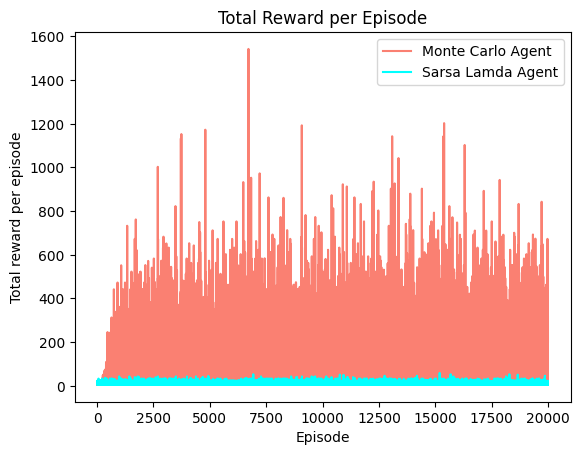

In [ ]:
plt.plot(x, rewards1, color='salmon',label="Monte Carlo Agent")
plt.plot(x, rewards2, color='cyan',label="Sarsa Lamda Agent")
plt.xlabel("Episode")
plt.ylabel("Total reward per episode")
plt.title("Total Reward per Episode")
plt.legend()
plt.show()

**Score per episode**

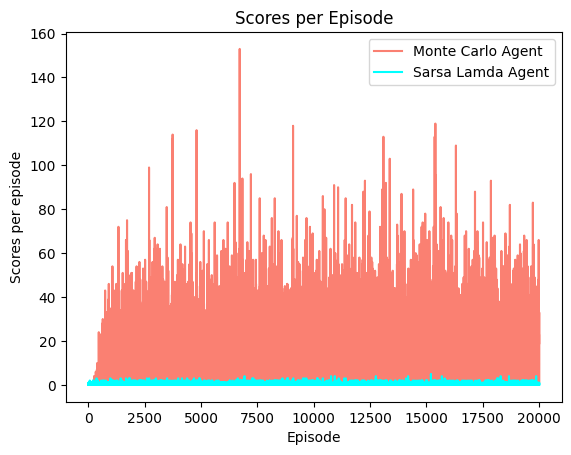

In [ ]:
plt.plot(x, scores1, color='salmon',label="Monte Carlo Agent")
plt.plot(x, scores2, color='cyan',label="Sarsa Lamda Agent")
plt.xlabel("Episode")
plt.ylabel("Scores per episode")
plt.title("Scores per Episode")
plt.legend()
plt.show()

# Convergence time

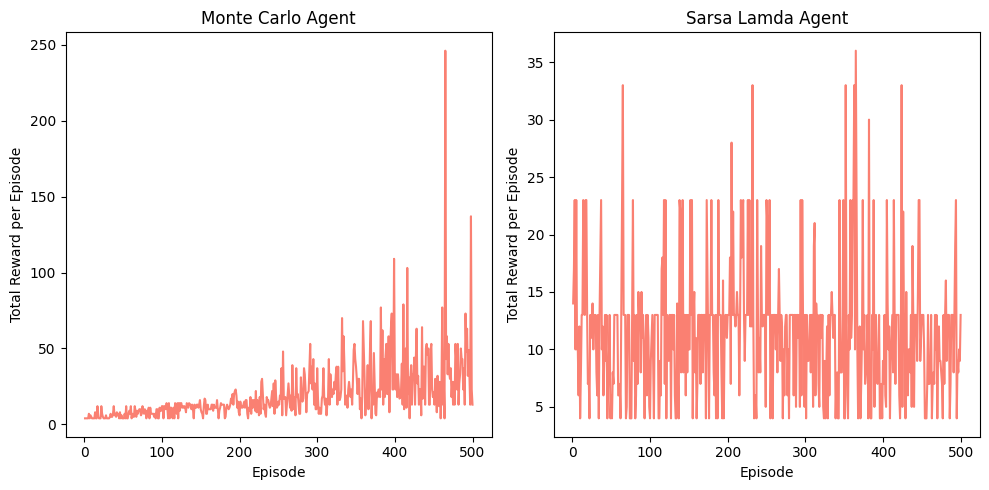

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(x[:500], rewards1[:500], color='salmon')
axs[0].set_title('Monte Carlo Agent')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Total Reward per Episode')

axs[1].plot(x[:500], rewards2[:500], color='salmon')
axs[1].set_title('Sarsa Lamda Agent')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Total Reward per Episode')

plt.tight_layout()
plt.show()

# Effect of changing the environment

**Training a first agent**

In [ ]:
Q, policy,rewards1,scores1 = mc_control_epsilon_greedy(env, num_episodes=50000, epsilon=0.1,discount_factor=0.9)

100%|██████████| 50000/50000 [09:23<00:00, 88.72it/s]


**Changing the environment and testing with the pretrained agent**

In [ ]:
env1 = gym.make('TextFlappyBird-v0', height = 30, width = 40, pipe_gap = 7)
Q1, policy1,rewards2,scores2 = mc_control_epsilon_greedy(env1, num_episodes=1000, epsilon=0.1,discount_factor=0.9,Q=Q)

100%|██████████| 1000/1000 [00:06<00:00, 149.31it/s]


**Training another agent in the new environment**

In [ ]:
Q2, policy2,rewards3,scores3 = mc_control_epsilon_greedy(env1, num_episodes=1000, epsilon=0.1,discount_factor=0.9)

100%|██████████| 1000/1000 [00:02<00:00, 462.44it/s]


**Results for 100 episodes**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


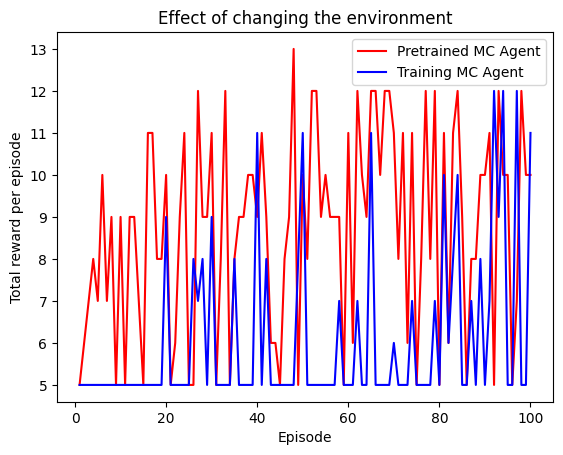

In [ ]:
plt.plot([i for i  in range(1,101)], rewards2[:100], color='red',label="Pretrained MC Agent")
plt.plot([i for i  in range(1,101)], rewards3[:100], color='blue',label="Training MC Agent")
plt.xlabel("Episode")
plt.ylabel("Total reward per episode")
plt.title("Effect of changing the environment")
plt.legend()
plt.show()

**Results for 1000 episodes**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


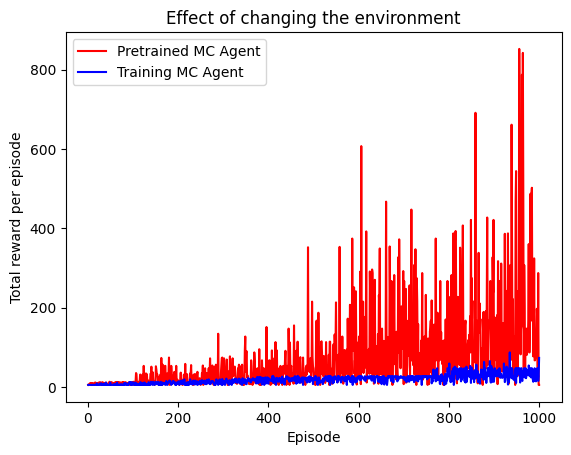

In [ ]:
plt.plot([i for i  in range(1,1001)], rewards2, color='red',label="Pretrained MC Agent")
plt.plot([i for i  in range(1,1001)], rewards3, color='blue',label="Training MC Agent")
plt.xlabel("Episode")
plt.ylabel("Total reward per episode")
plt.title("Effect of changing the environment")
plt.legend()
plt.show()

# State Value Functions

**State-Value Functions for MC Control**

In [ ]:
Q_10k, policy_10k,rewards_10k,scores_10k = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)
Q, policy,rewards_500k,scores_500k = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [2:09:10<00:00, 64.51it/s]


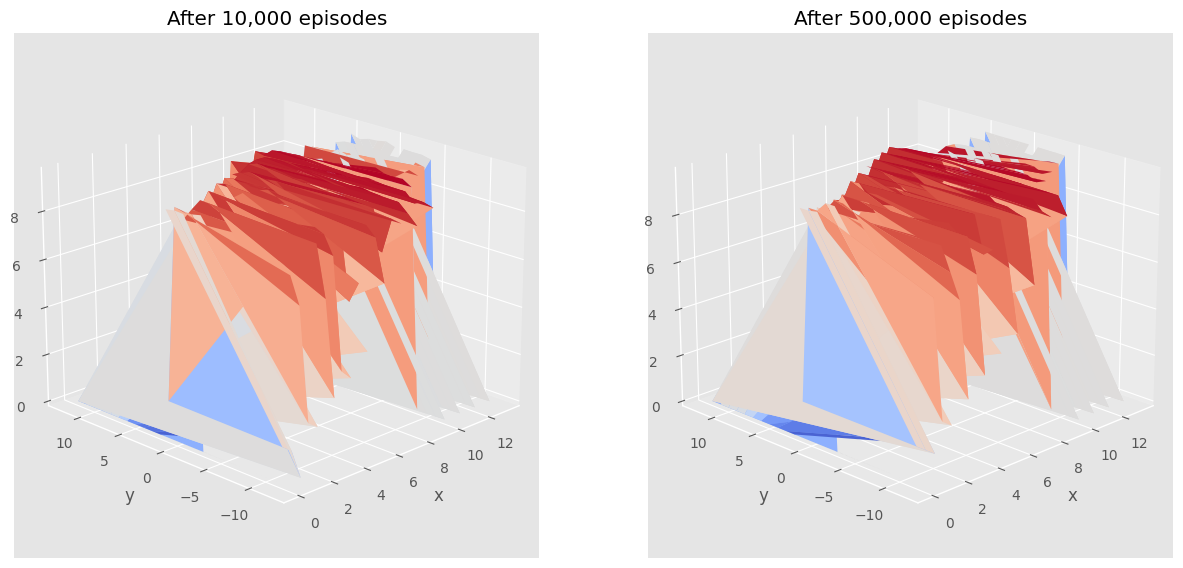

In [ ]:
def value_from_Q(Q, policy, n_actions):
    V = defaultdict(float)
    for state in Q:
        q_list = [Q[state][action] * policy(state)[action]  for action in range(n_actions)]
        V[state] = sum(q_list)
    return V

V_10k = value_from_Q(Q_10k, policy_10k, env.action_space.n)
V_500k = value_from_Q(Q, policy, env.action_space.n)

vstate_10k = defaultdict(list)
vstate_500k = defaultdict(list)

for i in itertools.product(range(0, 14),range(-12, 13)):
    x, y = i
    z_10k = V_10k[i]
    z_500k = V_500k[i]

    if z_10k is not None:
        vstate_10k["x"].append(x)
        vstate_10k["y"].append(y)
        vstate_10k["z"].append(z_10k)

    if z_500k is not None:
        vstate_500k["x"].append(x)
        vstate_500k["y"].append(y)
        vstate_500k["z"].append(z_500k)

vstate_10k["x"] = np.array(vstate_10k["x"]).reshape(-1, 14)
vstate_10k["y"] = np.array(vstate_10k["y"]).reshape(-1, 14)
vstate_10k["z"] = np.array(vstate_10k["z"]).reshape(-1, 14)



vstate_500k["x"] = np.array(vstate_500k["x"]).reshape(-1, 14)
vstate_500k["y"] = np.array(vstate_500k["y"]).reshape(-1, 14)
vstate_500k["z"] = np.array(vstate_500k["z"]).reshape(-1, 14)



fig = plt.figure(figsize = (15, 15))

ax1 = plt.subplot(2, 2, 1, projection='3d')
ax1.plot_surface( X = vstate_10k["x"],Y = vstate_10k["y"], Z= vstate_10k["z"],cmap='coolwarm')
ax1.set_title('After 10,000 episodes')
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.view_init(elev=20., azim=225)

ax3 = plt.subplot(2, 2, 2, projection='3d')
ax3.plot_surface(X = vstate_500k["x"], Y = vstate_500k["y"], Z= vstate_500k["z"], cmap='coolwarm')
ax3.set_title('After 500,000 episodes')
ax3.set_ylabel('y')
ax3.set_xlabel('x')
ax3.view_init(elev=20., azim=225)

plt.show()

**Approximate State-Value Functions for the Sarsa Lamda**

In [ ]:
all_reward_sums = {}
all_state_visits = {}

# Agent and environment parameters
agent1 = SarsaLamdaAgent()
steps_per_episode = []
# Set agent parameters
agent1.agent_init({
    "num_tilings": 12,
    "num_tiles": 12,
    "iht_size": 4096,
    "epsilon": 0.1,
    "gamma": 0.9,
    "lamda": 0.9,
    "alpha": 0.001,
    "initial_weights": 0.0,
    "method": "accumulating",
    "num_actions": 2
})
#Train the agent
num_episodes = 10000
for episode in tqdm(range(num_episodes)):
    state = env.reset()
    action = agent1.agent_start(state[0])
    done = False
    num_steps = 0
    while not done:
        next_state, reward, done,_,desc = env.step(action)
        action = agent1.agent_step(reward, next_state)
        num_steps += 1
    agent1.agent_end(reward)
    steps_per_episode.append(num_steps)


100%|██████████| 10000/10000 [00:15<00:00, 627.36it/s]


In [ ]:
all_reward_sums = {}
all_state_visits = {}

# Agent and environment parameters
agent2 = SarsaLamdaAgent()
steps_per_episode = []
# Set agent parameters
agent2.agent_init({
    "num_tilings": 12,
    "num_tiles": 12,
    "iht_size": 4096,
    "epsilon": 0.1,
    "gamma": 0.9,
    "lamda": 0.9,
    "alpha": 0.001,
    "initial_weights": 0.0,
    "method": "accumulating",
    "num_actions": 2
})
#Train the agent
num_episodes = 50000
for episode in tqdm(range(num_episodes)):
    state = env.reset()
    action = agent2.agent_start(state[0])
    done = False
    num_steps = 0
    while not done:
        next_state, reward, done,_,desc = env.step(action)
        action = agent2.agent_step(reward, next_state)
        num_steps += 1
    agent2.agent_end(reward)
    steps_per_episode.append(num_steps)


100%|██████████| 50000/50000 [01:28<00:00, 564.52it/s]


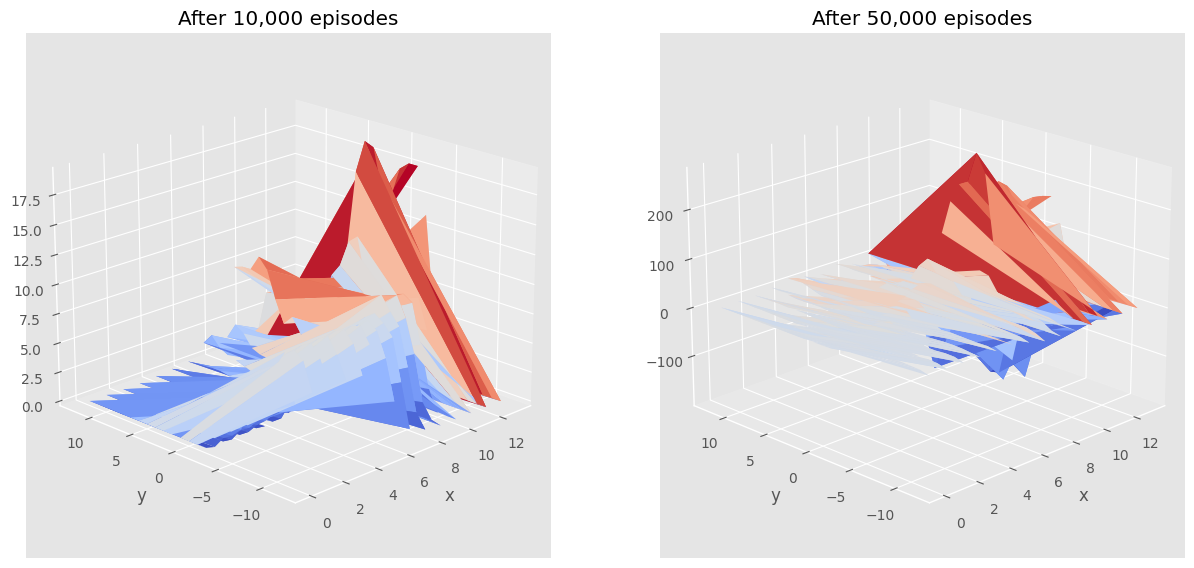

In [ ]:
import itertools
from mpl_toolkits.mplot3d import axes3d
matplotlib.style.use('ggplot')
vstate_10k = defaultdict(list)
vstate_500k = defaultdict(list)
for i in itertools.product(range(0, 14),range(-12, 13)):
    x, y = i
    z_10k = agent1.get_value((x,y))
    z_500k = agent2.get_value((x,y))
    if z_10k is not None:
        vstate_10k["x"].append(x)
        vstate_10k["y"].append(y)
        vstate_10k["z"].append(z_10k)
    if z_500k is not None:
        vstate_500k["x"].append(x)
        vstate_500k["y"].append(y)
        vstate_500k["z"].append(z_500k)

vstate_10k["x"] = np.array(vstate_10k["x"]).reshape(-1, 14)
vstate_10k["y"] = np.array(vstate_10k["y"]).reshape(-1, 14)
vstate_10k["z"] = np.array(vstate_10k["z"]).reshape(-1, 14)

vstate_500k["x"] = np.array(vstate_500k["x"]).reshape(-1, 14)
vstate_500k["y"] = np.array(vstate_500k["y"]).reshape(-1, 14)
vstate_500k["z"] = np.array(vstate_500k["z"]).reshape(-1, 14)


fig = plt.figure(figsize = (15, 15))

ax1 = plt.subplot(2, 2, 1, projection='3d')
ax1.plot_surface( X = vstate_10k["x"],Y = vstate_10k["y"], Z= vstate_10k["z"],cmap='coolwarm')
ax1.set_title('After 10,000 episodes')
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.view_init(elev=20., azim=225)

ax3 = plt.subplot(2, 2, 2, projection='3d')
ax3.plot_surface(X = vstate_500k["x"], Y = vstate_500k["y"], Z= vstate_500k["z"], cmap='coolwarm')
ax3.set_title('After 50,000 episodes')
ax3.set_ylabel('y')
ax3.set_xlabel('x')
ax3.view_init(elev=20., azim=225)

plt.show()

**Learned Policy for MC Control**

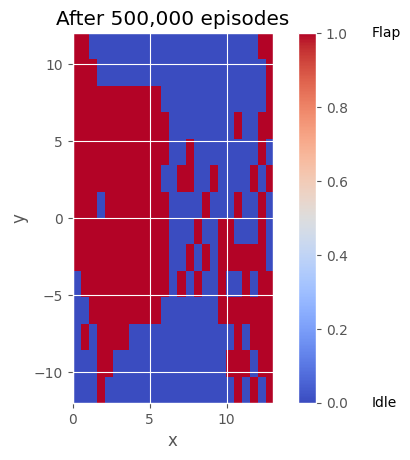

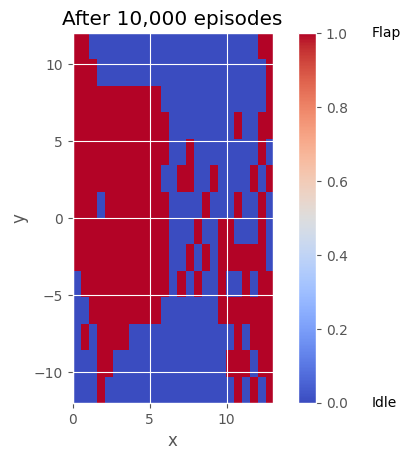

In [ ]:
flap_mat = np.zeros((14, 25), dtype=int)
flap_mat1 = np.zeros((14, 25), dtype=int)


for state in V_500k.keys():
    x, y = state
    mat = flap_mat
    mat[x, y] = np.argmax(policy(state))

for state in V_10k.keys():
    x, y = state
    mat1 = flap_mat1
    mat1[x, y] = np.argmax(policy(state))

plt.imshow(flap_mat, cmap='coolwarm',extent=(0, 13, -12, 12))
plt.title('After 500,000 episodes')
plt.ylabel('y')
cbar = plt.colorbar()

# Adding annotation to the colorbar
cbar.ax.text(4, 1, 'Flap', va='center', ha='left')
cbar.ax.text(4, 0, 'Idle', va='center', ha='left')
plt.xlabel('x')
plt.xlim((0, 13))
plt.show()

plt.imshow(flap_mat1, cmap='coolwarm',extent=(0, 13, -12, 12))
plt.title('After 10,000 episodes')
plt.ylabel('y')
cbar = plt.colorbar()

# Adding annotation to the colorbar
cbar.ax.text(4, 1, 'Flap', va='center', ha='left')
cbar.ax.text(4, 0, 'Idle', va='center', ha='left')
plt.xlabel('x')
plt.xlim((0, 13))
plt.show()

